In [23]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [24]:
import pandas as pd

In [25]:
data = pd.read_csv("./classification.csv")

In [26]:
data.sample(5)

,id,question,answer,intent
546,47,"Hi, sab thikai chha?","Hi! Sab thikai chha, tapai lai kasari madat ga...",greetings
1154,155,Kripaya malai yo saman ko stock barema thap ja...,Yo saman stock ma chha. Tapai le order garna s...,inquiry
1268,269,"Kripaya bhanidinuhos, yo saman stock ma ajhai ...",Santusht chhu! Yo saman stock ma ajhai chha.,inquiry
105,106,order garna kunei specific time cha?,"order garna specific time chaina, 24/7 online ...",order
757,258,"Namaste, sab thikai chha?","Namaste! Sab thikai chha, tapai lai kasari mad...",greetings


In [27]:
questions = data['question'].values
answers = data['answer'].values

In [28]:
# Sample dataset
# questions = [
#     "hello",
#     "how are you",
#     "what's your name",
#     "what do you do",
#     "goodbye"
# ]

# answers = [
#     "hi there",
#     "I'm doing well",
#     "I'm a chatbot",
#     "I help answer questions",
#     "bye, take care"
# ]

In [29]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
vocab_size = len(tokenizer.word_index) + 1

In [30]:
# Convert text to sequences
encoder_input_data = tokenizer.texts_to_sequences(questions)
decoder_input_data = tokenizer.texts_to_sequences(answers)
decoder_target_data = tokenizer.texts_to_sequences(answers)

In [31]:
# Pad sequences
max_len = 10
encoder_input_data = pad_sequences(encoder_input_data, maxlen=max_len, padding='post')
decoder_input_data = pad_sequences(decoder_input_data, maxlen=max_len, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, maxlen=max_len, padding='post')

In [32]:
# Model parameters
embedding_dim = 256
lstm_units = 128
dropout_rate = 0.2

In [33]:
# Encoder
encoder_inputs = tf.keras.layers.Input(shape=(max_len,))
encoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = tf.keras.layers.LSTM(lstm_units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]


In [34]:
# Decoder
decoder_inputs = tf.keras.layers.Input(shape=(max_len,))
decoder_embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
decoder_lstm = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_dense = tf.keras.layers.Dense(vocab_size, activation='softmax')

In [35]:
decoder_embedded = decoder_embedding(decoder_inputs)
decoder_outputs, _, _ = decoder_lstm(decoder_embedded, initial_state=encoder_states)
decoder_outputs = tf.keras.layers.Dropout(dropout_rate)(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)


In [36]:
# Define the model
model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [37]:
# Training
model_history = model.fit(
    [encoder_input_data, decoder_input_data], 
    decoder_target_data,
    batch_size=2,
    epochs=300,
    verbose=0
)

KeyboardInterrupt: 

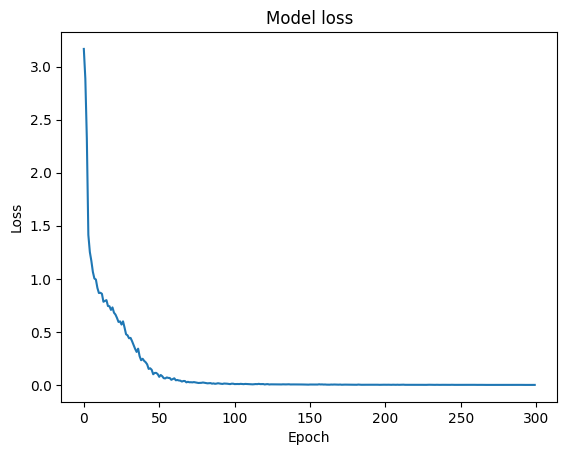

In [12]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['loss'])
plt.title('Model loss')

plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.show()

In [13]:
# Inference model
encoder_model = tf.keras.Model(encoder_inputs, encoder_states)

decoder_state_input_h = tf.keras.layers.Input(shape=(lstm_units,))
decoder_state_input_c = tf.keras.layers.Input(shape=(lstm_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_embedding(decoder_inputs), initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = tf.keras.Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [14]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, max_len))
    target_seq[0, 0] = tokenizer.word_index.get('start', 1)
    
    output_text = []
    for i in range(max_len):
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, i, :])
        if sampled_token_index == 0 or len(output_text) > max_len:
            break
            
        output_text.append(sampled_token_index)
        target_seq[0, i] = sampled_token_index
        states_value = [h, c]
    
    return ' '.join([list(tokenizer.word_index.keys())[list(tokenizer.word_index.values()).index(i)-1] 
                    for i in output_text])

In [15]:
# Example inference
def chat():
    while True:
        user_input = input("You: ")
        if user_input.lower() in ['quit', 'exit']:
            break
            
        test_seq = tokenizer.texts_to_sequences([user_input])
        test_seq = pad_sequences(test_seq, maxlen=max_len, padding='post')
        response = decode_sequence(test_seq)
        print("Bot:", response)

In [16]:
chat()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bot: questions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Bot: do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bot: questions
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Bot: chatbot
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Bot: do
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Bot: questi

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 3.1563
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.8164 
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1398 
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3059 
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3994 
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2612 
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0327 
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0837 
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9514 
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9235
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8982 
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8764 
Epoch 13/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9124 
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8223 
Epoch 15/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7487 
Epoch 16/100
3/3 ━━━